In [475]:
import pandas as pd

# filename = "/home/piotr/Documents/mgr/uwb-rs/data-processing/data/triangulated/2023-05-24-13:52:11.266488_P3-1-6-5_normalized_high_up.csv"
filename = "data/triangulated/2023-05-24-14:35:08.828772P3-1-6-5_high_los.csv"
df = pd.read_csv(filename)
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [476]:
# Units conversion - m and m/s^2
df[["x", "y"]] /= 1000
df[["acc_x", "acc_y"]] *= 9.80665

In [477]:
import numpy as np

dt = df["timestamp"].diff().mean().to_pytimedelta().microseconds/10**6

F = np.matrix([[1, 0, dt**2/2, 0      ],
               [0, 1, 0,       dt**2/2],
               [0, 0, 1,       0      ],
               [0, 0, 0,       1      ]])
H = np.matrix(np.eye(4))

Q = np.matrix(np.eye(4))
R = np.matrix(np.diag([df["x"].std()**2,df["y"].std()**2,df["acc_y"].std()**2,df["acc_z"].std()**2]))
# R = np.matrix(np.eye(4))*0.001
P = np.matrix(np.eye(4))*10000
x = np.matrix('0. 0. 0. 0.').T

In [478]:
def kalman_step(x, P, measurement, R, motion, Q, F, H):
    # UPDATE x, P based on measurement m    
    # distance between measured and current position-belief
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R  # residual convariance
    K = P * H.T * S.I    # Kalman gain
    x = x + K*y
    I = np.matrix(np.eye(F.shape[0])) # identity matrix
    P = (I - K*H)*P

    # PREDICT x, P based on motion
    x = F*x + motion
    P = F*P*F.T + Q
    return x, P

In [479]:
# Delete gravity
df[["acc_x","acc_y","acc_z"]] -= df[["acc_x","acc_y","acc_z"]].head(15).mean()
data = df

In [480]:
filtered = []
motion = np.matrix('0. 0. 0. 0.').T
for _, measurement in data[["x", "y", "acc_y", "acc_z"]].iterrows():
    measurement = measurement.to_list()
    measurement = [measurement[0],   # x
                   measurement[1],   # y
                   measurement[2],   # acc_x = acc_y_devboard
                   - measurement[3]] # acc_y = -acc_z_devboard
    # display(measurement)
    x, P = kalman_step(x, P, measurement, R, motion, Q, F, H)
    filtered.append(x.tolist())

filtered_pos = [[x[0], y[0]] for (x, y, _, _) in filtered]
filtered_acc = [[x[0], y[0]] for (_, _, x, y) in filtered]

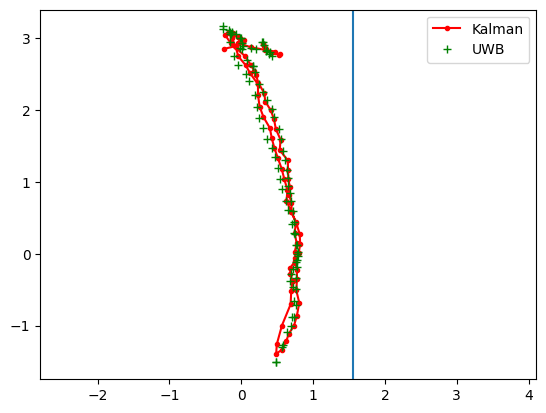

In [481]:
import matplotlib.pyplot as plt

x, y = zip(*filtered_pos)

plt.plot(x, y, "r.-")

plt.plot((df.x).to_list(), (df.y).to_list(), "g+")
plt.axis('equal')
plt.axvline(1.560)
plt.legend(["Kalman", "UWB"])
# data[["acc_x", "acc_y"]].plot.line()
plt.show()

In [482]:
import plotly.express as px

x, y = zip(*filtered_acc)
px.line(y=[x, y, df.acc_x, df.acc_y])